# build molecule, taper and construct CS-VQE model

In [1]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'Be_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

Be_STO-3G_SINGLET
Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10


In [2]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 10 -> 5 qubits

The following stabilizers were identified:

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ


In [3]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'IIX', 'ZZX', 'IXI', 'ZXZ', 'IXX', 'IYY', 'XII', 'XZZ', 'XIX', 'YIY', 'XXI', 'YYI'],
              coeffs=[-12.488598  +0.j,  -0.85829425+0.j,  -0.85829425+0.j,   0.02304318+0.j,
  -0.85829425+0.j,   0.02304318+0.j,   0.02304318+0.j,   0.64247074+0.j,
  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j]), coeff=1.0)

In [4]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]

ucc_trunc = ucc_cs#.sort()[:40]
anz_cs = AnsatzOp(ucc_trunc.symp_matrix, ucc_trunc.coeff_vec)

obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
vqe_result = obs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs
)

opt_params = vqe_result[0]['x']
vqe_result[0]['fun'] - molecule.fci_energy

0.0003265064114810201

In [5]:
from qiskit import QuantumCircuit
ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz = ansatz.compose(anz_cs.to_QuantumCircuit(bind_params=False))
ansatz.draw()

░ ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐          »
q_0: ─░─┤ Sdg ├┤ H ├┤ Rz(-2*P[0]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■───────»
      ░ └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘┌─┴─┐     »
q_1: ─░───────────────────────────────────────░─────────────┤ X ├──■──»
      ░                                       ░             └───┘┌─┴─┐»
q_2: ─░───────────────────────────────────────░──────────────────┤ X ├»
      ░                                       ░                  └───┘»
«                              ┌───┐┌───┐ ░                                 »
«q_0: ──────────────────────■──┤ H ├┤ S ├─░─────────────────────────────────»
«                         ┌─┴─┐└───┘└───┘ ░ ┌─────┐┌───┐┌─────────────┐┌───┐»
«q_1: ─────────────────■──┤ X ├───────────░─┤ Sdg ├┤ H ├┤ Rz(-2*P[2]) ├┤ H ├»
«     ┌─────────────┐┌─┴─┐└───┘           ░ └─────┘└───┘└─────────────┘└───┘»
«q_2: ┤ Rz(-2*P[1]) ├┤ X ├────────────────░─────────────────────────────────»
«     └─────────────┘└───┘                ░                                 »
«           ░                                                           ░ »
«q_0: ──────░───────────────■─────────────────────────────■─────────────░─»
«     ┌───┐ ░ ┌─────┐┌───┐┌─┴─┐                         ┌─┴─┐┌───┐┌───┐ ░ »
«q_1: ┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├──■───────────────────■──┤ X ├┤ H ├┤ S ├─░─»
«     └───┘ ░ └─────┘└───┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘└───┘└───┘ ░ »
«q_2: ──────░──────────────────┤ X ├┤ Rz(-2*P[3]) ├┤ X ├────────────────░─»
«           ░                  └───┘└─────────────┘└───┘                ░ »
«                                           ░                                 »
«q_0: ──────────────────────────────────────░────■────────────────────────────»
«                                           ░  ┌─┴─┐                          »
«q_1: ──────────────────────────────────────░──┤ X ├────────■─────────────────»
«     ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌┴───┴┐┌───┐┌─┴─┐┌─────────────┐»
«q_2: ┤ Sdg ├┤ H ├┤ Rz(-2*P[4]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├┤ Rz(-2*P[5]) ├»
«     └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘└───┘└─────────────┘»
«                     ░ 
«q_0: ───────■────────░─
«          ┌─┴─┐      ░ 
«q_1: ──■──┤ X ├──────░─
«     ┌─┴─┐├───┤┌───┐ ░ 
«q_2: ┤ X ├┤ H ├┤ S ├─░─
«     └───┘└───┘└───┘ ░

In [6]:
from qiskit.quantum_info import Statevector
from symmer.symplectic import QuantumState
qc = ansatz.bind_parameters(opt_params)
psi = Statevector.from_instruction(qc).to_dict()
state_matrix, coeff_vec = zip(*[([int(i) for i in bstring], coeff) for bstring, coeff in psi.items()])
state_matrix = np.array(state_matrix)
coeff_vec = np.array(coeff_vec)

psi = QuantumState(state_matrix, coeff_vec)
psi.conjugate * ham_cs * psi - molecule.fci_energy

(0.0003613743596702079-1.386064397710712e-32j)

In [7]:
#from qiskit.circuit.library import EfficientSU2
#ansatz = EfficientSU2(n_qubits)
#ansatz.decompose().draw()

In [8]:
#import qiskit.circuit.library.n_local as lib_local

#ansatz = getattr(lib_local, "EfficientSU2")
#ansatz(3).decompose().draw()

# VQE using ``symmer-vqe-Ve6OdoVd8X`` runtime program

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService
# only run the following the first time you connect to the service
#token = "a26e0769ddee03aa5f95f38edb1266efa1190059c7d60c1784ca3ec1e4c3c84bc375947c2bc8d2bc4ab39e32ea64ae6376b1f631936a416c7b8bdaed8b94a9cb"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [18]:
#program_id = service.upload_program(data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
program_id = 'symmer-vqe-Ve6OdoVd8X'

In [28]:
#service.update_program(program_id=program_id, data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
# service.delete_program(program_id) # to delete program

In [29]:
prog = service.program(program_id)
print(prog)

symmer-vqe-Ve6OdoVd8X:
  Name: symmer_vqe
  Description: VQE program using symmer
  Creation date: 2022-06-22T18:15:41.099082Z
  Update date: 2022-06-23T11:38:02.334057Z
  Max execution time: 100000
  Backend requirements:
    none
  Input parameters:
    Properties:
        - ansatz:
            Description: Parametrized Ansatz
            Type: QuantumCircuit
            Required: True
        - init_params:
            Default: None
            Description: Initial vector of parameters. This is a numpy array.
            Type: array
            Required: False
        - maxiter:
            Default: 10
            Description: Maximum number of optimizer iterations.
            Type: int
            Required: False
        - n_groups:
            Default: 5
            Description: The number of classical shadow groups.
            Type: integer
            Required: False
        - n_shots:
            Default: 2**12
            Description: The number of shots used for each circui

In [30]:
operator = ham_cs

QWC_decomposition = list(
            ObservableGraph(
                operator.symp_matrix, 
                operator.coeff_vec
            ).clique_cover(
                clique_relation='QWC', 
                colouring_strategy='largest_first'
            ).values()
        )
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

In [31]:
for name in service.backends():
    print(f'{name.name} backend with {name.num_qubits} qubits has {name.status().pending_jobs} queued jobs.')

ibmq_qasm_simulator backend with 32 qubits has 3 queued jobs.
ibmq_armonk backend with 1 qubits has 2 queued jobs.
ibmq_lima backend with 5 qubits has 38 queued jobs.
ibmq_belem backend with 5 qubits has 32 queued jobs.
ibmq_quito backend with 5 qubits has 81 queued jobs.
simulator_statevector backend with 32 qubits has 2 queued jobs.
simulator_mps backend with 100 qubits has 2 queued jobs.
simulator_extended_stabilizer backend with 63 qubits has 2 queued jobs.
simulator_stabilizer backend with 5000 qubits has 2 queued jobs.
ibmq_manila backend with 5 qubits has 243 queued jobs.
ibm_nairobi backend with 7 qubits has 22 queued jobs.
ibm_oslo backend with 7 qubits has 29 queued jobs.


In [55]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    "ansatz": ansatz,
    "observable": ham_cs.to_PauliSumOp,
    "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    "init_params": None,
    "optimizer": 'CG',
    "n_groups":0,
    "maxiter": 10,
    "n_shots": 2**15, # 18 < np.log2(0.0016**-2) < 19
}

In [56]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [57]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
#print(job.error_message())

Job ID: caq51r1ihlmte2bm6o2g
Job status: JobStatus.QUEUED


In [82]:
print(molecule.hf_energy, molecule.fci_energy)
job.interim_results()

-14.351880476202023 -14.403655108067682


['VQE complete',
 'Optimization step #23: energy = -14.41056548910617',
 'Optimization step #22: energy = -14.403632521583408',
 'Optimization step #21: energy = -14.402250996788643',
 'Optimization step #20: energy = -14.398377004158291',
 'Optimization step #19: energy = -14.407487947574635',
 'Optimization step #18: energy = -14.393831896871157',
 'Optimization step #17: energy = -14.40012644765336',
 'Optimization step #16: energy = -14.402643445800923',
 'Optimization step #15: energy = -14.404774882597781',
 'Optimization step #14: energy = -14.401642961447275',
 'Optimization step #13: energy = -14.40692951020318',
 'Optimization step #12: energy = -14.404576236100059',
 'Optimization step #11: energy = -14.406941282322489',
 'Optimization step #10: energy = -14.395278798888352',
 'Optimization step #9: energy = -14.399770222051933',
 'Optimization step #8: energy = -14.402051151073298',
 'Optimization step #7: energy = -14.398315241458619',
 'Optimization step #6: energy = -14.

In [83]:
vqe_result, interim_values = job.result()

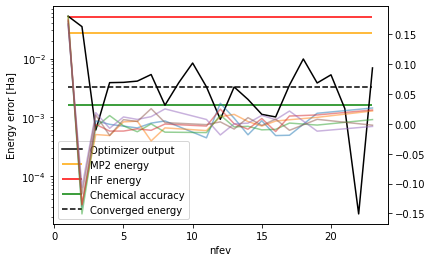

In [84]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.hlines(0.0016, 1, len(X), color='green', label='Chemical accuracy')

axis.plot(X, abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(abs(vqe_result['fun'] - molecule.fci_energy), 1, len(X), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

axis_param = axis.twinx()
X_grad, Y_grads = zip(*interim_values['gradients'])
for param_grad in zip(*Y_grads):
    axis_param.plot(X_grad, param_grad, alpha=0.5)

axis.legend()
plt.show()

In [57]:
100_000/60/60 #hours

27.77777777777778

# classical shadows...

In [111]:
ham_cs

-12.489+0.000j III +
-0.858+0.000j IIZ +
-0.858+0.000j IZI +
0.023+0.000j IZZ +
-0.858+0.000j ZII +
0.023+0.000j ZIZ +
0.023+0.000j ZZI +
0.642+0.000j ZZZ +
-0.043+0.000j IIX +
-0.043+0.000j ZZX +
-0.043+0.000j IXI +
-0.043+0.000j ZXZ +
0.012+0.000j IXX +
0.012+0.000j IYY +
-0.043+0.000j XII +
-0.043+0.000j XZZ +
0.012+0.000j XIX +
0.012+0.000j YIY +
0.012+0.000j XXI +
0.012+0.000j YYI

In [161]:
from qiskit.quantum_info import PauliTable

random_symp_vec = np.random.randint(0,2,(1,2*n_qubits), dtype=bool)
print(PauliTable(random_symp_vec).to_labels())

def QWC_terms(operator, basis_symp_vec):
    X_basis, Z_basis = np.hsplit(basis_symp_vec, 2)
    X_block, Z_block = np.hsplit(operator.primitive.table.array, 2)

    non_I = (X_block | Z_block) & (X_basis | Z_basis)
    X_match = np.all((X_block & non_I) == (X_basis & non_I), axis=1)
    Z_match = np.all((Z_block & non_I) == (Z_basis & non_I), axis=1)

    QWC_mask = X_match & Z_match

    return operator[QWC_mask]

QWC_terms(operator=ham_cs.to_PauliSumOp, basis_symp_vec=random_symp_vec)

['ZIZ']


/tmp/ipykernel_54835/1998727818.py:8: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  X_block, Z_block = np.hsplit(operator.primitive.table.array, 2)


PauliSumOp(SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'IXI', 'ZXZ'],
              coeffs=[-12.488598  +0.j,  -0.85829425+0.j,  -0.85829425+0.j,   0.02304318+0.j,
  -0.85829425+0.j,   0.02304318+0.j,   0.02304318+0.j,   0.64247074+0.j,
  -0.04340449+0.j,  -0.04340449+0.j]), coeff=1.0)

In [180]:
arr=np.random.randint(0,2,(4,2*n_qubits), dtype=bool)
arr

array([[ True, False,  True, False,  True,  True],
       [False, False,  True,  True, False, False],
       [False, False,  True,  True, False,  True],
       [False,  True, False, False,  True, False]])

In [181]:
for a,b in zip(*np.hsplit(arr,2)):
    print(a, b)

[ True False  True] [False  True  True]
[False False  True] [ True False False]
[False False  True] [ True False  True]
[False  True False] [False  True False]


# program metadata

In [24]:
meta = {
    "name": "symmer_vqe",
    "description": "VQE program using symmer",
    "max_execution_time": 100000,
    "spec": {},
}

In [25]:
meta["spec"]["parameters"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "properties": {
        "ansatz": {
            "description": "Parametrized Ansatz",
            "type": "QuantumCircuit",
        },
        "observable_groups": {
            "description": "Decomposition of operator into groups, e.g. qubit-wise commuting",
            "type": "List[Union[PauliSumOp, PauliOp]]",
            "default": "None"
        },
        "observable": {
            "description": "The observable on which we wish to perform eigenvalue estimation",
            "type": "PauliSumOp",
            "default": "None",
        },
        "maxiter": {
            "description": "Maximum number of optimizer iterations.",
            "type": "int",
            "default": "10",
        },
        "init_params": {
            "description": "Initial vector of parameters. This is a numpy array.",
            "type": "array",
            "default": "None",
        },
        "n_shots": {
            "description": "The number of shots used for each circuit evaluation.",
            "type": "integer",
            "default": "2**12",
        },
        "n_groups": {
            "description": "The number of classical shadow groups.",
            "type": "integer",
            "default": "5",
        },
        "use_measurement_mitigation": {
            "description": "Use measurement mitigation, default=False.",
            "type": "boolean",
            "default": "False",
        },
    },
    "required": ["ansatz"],
}

meta["spec"]["return_values"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Tuple of final result in SciPy optimizer format and dictionary of interim values",
    "type": "Tuple[scipy.optimize.optimize.OptimizeResult, Dict]",
}

meta["spec"]["interim_results"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Parameter vector at current optimization step. This is a numpy array.",
    "type": "array",
}